<p>Saat ini terdapat sangat banyak aplikasi mobile dengan berbagai macam kategori, ada yang gratis untuk di install dan juga ada yang berbayar. Dalam notebook ini, akan dilakukan analisis komprehensif terhadap pasar aplikasi Android dengan membandingkan lebih dari sepuluh ribu aplikasi di Play Store dalam berbagai kategori. Melalui analisis ini, akan ditemukan beberapa insight dalam data untuk menyusun strategi untuk mendorong pertumbuhan dan retensi user.</p>
<p>Dataset yang digunakan ada dua, yaitu:</p>
<ul>
<li><code>apps.csv</code>: berisi semua detail aplikasi di Play Store. Terdapat 13 columns/features yang menjelaskan aplikasi tertentu.</li>
<li><code>user_reviews.csv</code>: berisi 100 review untuk masing-masing aplikasi. Teks dalam setiap review telah diproses dan dikaitkan dengan tiga label yaitu Sentimen (Positif, Negatif, atau Netral), Polaritas Sentimen, dan Subjektivitas Sentimen.</li>
</ul>

<p>Dataset berasal dari <a href="https://www.kaggle.com/datasets/yassershrief/goggle-play-data">link berikut.</a>

In [121]:
import pandas as pd
import numpy as np

apps_with_duplicates = pd.read_csv('./datasets/apps.csv')

apps = apps_with_duplicates.drop_duplicates()

print('Jumlah aplikasi dalam dataset = ', apps.shape)
print(apps.sample(5))


Jumlah aplikasi dalam dataset =  (9659, 14)
      Unnamed: 0                       App           Category  Rating  \
6831        7891  CT Pulmonary Angiography            MEDICAL     NaN   
2553        3281       Digital Alarm Clock              TOOLS     4.2   
5155        6151            BG Middle East  AUTO_AND_VEHICLES     NaN   
6637        7696              Foothills CP             FAMILY     5.0   
4678        5659           Au Weather Free            WEATHER     4.0   

      Reviews  Size     Installs  Type Price Content Rating           Genres  \
6831        0   4.9         100+  Free     0       Everyone          Medical   
2553   118439  16.0  10,000,000+  Free     0       Everyone            Tools   
5155        1   9.4          10+  Free     0       Everyone  Auto & Vehicles   
6637        4   7.8         100+  Free     0           Teen        Education   
4678     1185   5.0     100,000+  Free     0       Everyone          Weather   

           Last Updated Current Ver 

## 1. Data Pre-processing
<p>Data Pre-processing adalah salah satu subtask yang paling penting dalam project yang berkaitan dengan data. Walaupun prosesnya cukup rumit dan membosankan, tahapan ini tidak boleh dilewati karena data yang dimiliki harus bersih dan memiliki formatting yang konsisten.</p>
<p>Dengan melihat data sampel, terlihat bahwa beberapa data dalam column <code>Installs</code> dan <code>Price</code> memiliki karakter-karakter yang berbeda seperti (<code>+</code> <code>,</code> <code>$</code>). Hal ini mencegah kolom-kolom tersebut untuk memiliki tipe data numerik , sehingga tidak ideal dan sulit untuk digunakan dalam perhitungan matematis. Idealnya, kolom-kolom ini hanya berisi angka-angka dari [0-9].</p>
<p>Maka dari itu, harus dilakukan pre-processing untuk membersihkan dan mengubah data-data yang tidak sesuai.

In [122]:
# check the null values
print('\nJumlah nilai null dalam setiap kolom:')
print(apps.isnull().sum())



Jumlah nilai null dalam setiap kolom:
Unnamed: 0           0
App                  0
Category             0
Rating            1463
Reviews              0
Size              1227
Installs             0
Type                 0
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64


In [123]:
apps = apps.dropna()
print(apps.isnull().sum())


Unnamed: 0        0
App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64


In [124]:
chars_to_remove = ['+', ',', '$']
cols_to_clean = ['Installs', 'Price']

for col in cols_to_clean:
    for char in chars_to_remove:
        apps[col] = apps[col].apply(lambda x: x.replace(char, ''))

print(apps.info())


<class 'pandas.core.frame.DataFrame'>
Index: 7021 entries, 0 to 9658
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      7021 non-null   int64  
 1   App             7021 non-null   object 
 2   Category        7021 non-null   object 
 3   Rating          7021 non-null   float64
 4   Reviews         7021 non-null   int64  
 5   Size            7021 non-null   float64
 6   Installs        7021 non-null   object 
 7   Type            7021 non-null   object 
 8   Price           7021 non-null   object 
 9   Content Rating  7021 non-null   object 
 10  Genres          7021 non-null   object 
 11  Last Updated    7021 non-null   object 
 12  Current Ver     7021 non-null   object 
 13  Android Ver     7021 non-null   object 
dtypes: float64(2), int64(2), object(10)
memory usage: 822.8+ KB
None


## 2. Merubah Tipe Data
<p>Setelah menghapus karakter yang tidak sesuai dengan datanya, kolom-kolom <code>Installs</code> dan <code>Price</code> memiliki tipe data <code>object</code>, namun seharusnya kolom-kolom tersebut memiliki tipe data <code>float</code>. Hal tersebut terjadi karena sebelumnya kolom-kolom tersebut memiliki data yang bercampuran antara <code>int</code> dan <code>char</code> atau <code>string</code>.

In [125]:
apps['Installs'] = apps['Installs'].astype('float64')

apps['Price'] = apps['Price'].astype('float64')

print(apps.dtypes)


Unnamed: 0          int64
App                object
Category           object
Rating            float64
Reviews             int64
Size              float64
Installs          float64
Type               object
Price             float64
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object


## 3. Analisis Kategori-Kategori Aplikasi
<p>Dengan lebih dari 1 Billion Active Users (BAU) di 190 negara di seluruh dunia, Play Store menjadi platform yang integral untuk membangun audiens dan pasar digital secara global. Play Store memiliki peranan penting terhadap bisnis yang sedang atau akan melakukan ekspansi secara digital karena bisnis tersebut perlu untuk membuat aplikasi yang telah dibuat lebih cepat dan mudah ditemukan di Play Store.

Dalam upaya untuk meningkatkan pengalaman pencarian secara keseluruhan, Google melakukan konsep pengelompokan aplikasi ke dalam beberapa kategori.</p>
<p>Hal ini memicu pertanyaan-pertanyaan berikut:</p>
<ul>
<li>Kategori apa yang memiliki pangsa atau bagian aplikasi (aktif) tertinggi di Play Store?</li>
<li>Apakah ada kategori spesifik yang mendominasi Play Store?</li>
<li>Kategori apa yang memiliki jumlah aplikasi yang paling sedikit?</li>
</ul>

In [126]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

num_categories = apps['Category'].nunique()
print('Jumlah kategori dalam Play Store = ', num_categories)

num_apps_in_category = apps['Category'].value_counts()

sorted_num_apps_in_category = num_apps_in_category.sort_values(ascending=False)
print(sorted_num_apps_in_category)

data = [go.Bar(
        x = num_apps_in_category.index,
        y = num_apps_in_category.values,
)]

plotly.offline.iplot(data)


Jumlah kategori dalam Play Store =  33
Category
FAMILY                 1511
GAME                    832
TOOLS                   625
PERSONALIZATION         274
LIFESTYLE               269
MEDICAL                 266
FINANCE                 258
PRODUCTIVITY            223
BUSINESS                222
SPORTS                  221
PHOTOGRAPHY             204
HEALTH_AND_FITNESS      191
COMMUNICATION           188
SOCIAL                  156
NEWS_AND_MAGAZINES      154
SHOPPING                146
BOOKS_AND_REFERENCE     141
TRAVEL_AND_LOCAL        141
DATING                  122
VIDEO_PLAYERS           112
MAPS_AND_NAVIGATION      94
EDUCATION                88
FOOD_AND_DRINK           72
ENTERTAINMENT            64
AUTO_AND_VEHICLES        63
LIBRARIES_AND_DEMO       60
ART_AND_DESIGN           58
HOUSE_AND_HOME           50
WEATHER                  50
COMICS                   47
PARENTING                44
EVENTS                   38
BEAUTY                   37
Name: count, dtype: int64


## 4. Analisis Distribusi Rating Aplikasi
<p>Setelah melihat pangsa pasar untuk setiap kategori aplikasi, akan dilakukan analisis terkait rata-rata performa semua aplikasi. Rating aplikasi (dalam skala 1 sampai 5) berdampak pada discoverability, app conversion, dan brand image perusahaan secara keseluruhan. Dalam distribusi aplikasi, Rating menjadi salah satu KPI untuk menilai performa aplikasi tersebut.</p>
<p>Setelah dilakukan analisis, ditemukan bahwa rata-rata Rating di seluruh kategori aplikasi adalah <code>4.17</code>. Plot histogram miring ke kiri (left-skewed) menunjukkan bahwa sebagian besar aplikasi memiliki Rating tinggi dengan hanya beberapa pengecualian pada aplikasi dengan Rating rendah.</p>

In [127]:
avg_app_rating = np.mean(apps['Rating'])
print('Average app rating = ', avg_app_rating)

data = [go.Histogram(
        x = apps['Rating']
)]

layout = {'shapes': [{
              'type' :'line',
              'x0': avg_app_rating,
              'y0': 0,
              'x1': avg_app_rating,
              'y1': 1000,
              'line': { 'dash': 'dashdot'}
          }]
          }

layout.update({'title': 'Distribusi Aplikasi Berdasarkan Rating',
			   'xaxis': {'title': 'Rating'},
			   'yaxis': {'title': 'Jumlah Aplikasi'}})

plotly.offline.iplot({'data': data, 'layout': layout})


Average app rating =  4.160703603475289


## 5. Analisis Ukuran (Size) dan Harga (Price) Aplikasi
<p>Jika ukuran aplikasi terlalu besar, mungkin akan sulit atau mahal bagi user untuk men-download aplikasi tersebut. Waktu download yang lama dapat membuat user tidak ingin men-download atau menggunakan aplikasi yang telah dibuat. Selain itu, terdapat pertimbangan terkait storage setiap device yang digunakan user berbeda-beda dan terbatas. 

Terkait harga, secara umum user ingin aplikasi yang digunakan adalah aplikasi yang gratis.

Analisis ini memicu beberapa pertanyaan tambahan seperti:</p>

<p>Strategi efektif apa yang dapat digunakan untuk menentukan ukuran dan harga aplikasi agar meningkatkan jumlah user dan menahan retensi user?</p>

<ul>
<li>Apakah ukuran aplikasi memengaruhi rating? </li>
<li>Apakah pengguna peduli dengan aplikasi yang berat secara sistem atau mereka lebih suka aplikasi yang ringan? </li>
<li>Apakah harga aplikasi memengaruhi rating? </li>
<li>Apakah pengguna selalu lebih memilih aplikasi yang gratis daripada aplikasi yang berbayar?</li>
</ul>

<p>Hasil dari analisis ini adalah ditemukan bahwa sebagian besar aplikasi dengan rating teratas (rating di atas 4) memiliki ukuran sekitar antara 2 MB hingga 20 MB serta sebagian besar aplikasi memiliki harga di bawah $10</p>

Text(0.5, 0.98, 'Rating vs Price')

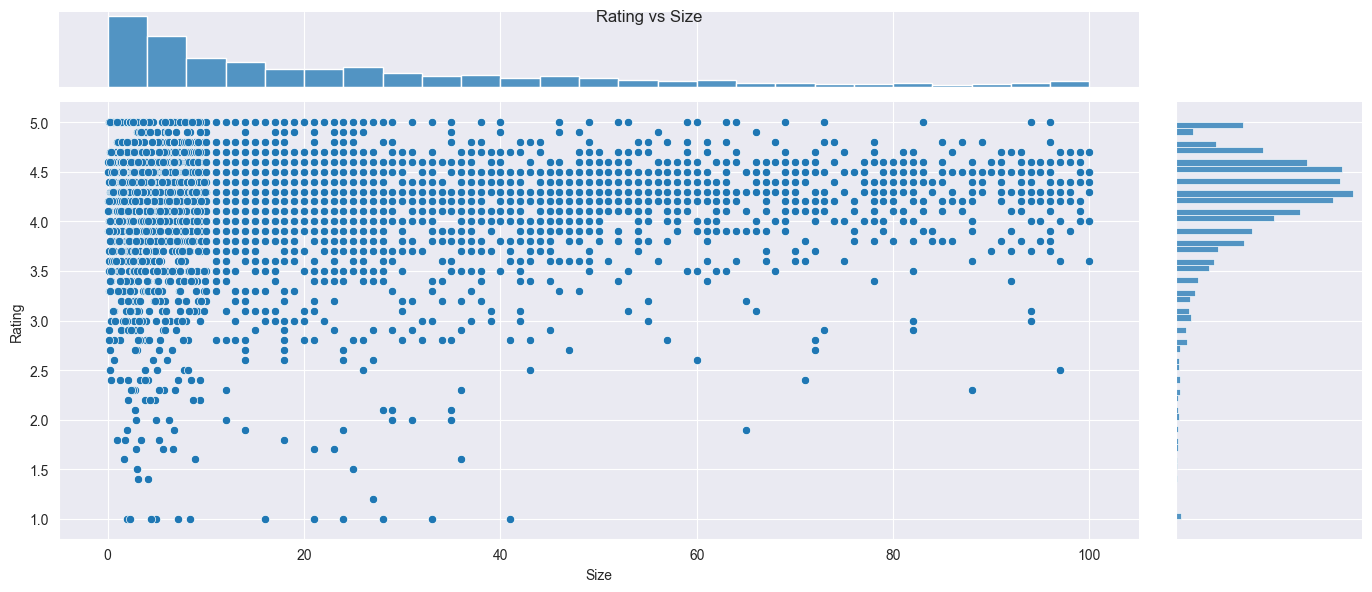

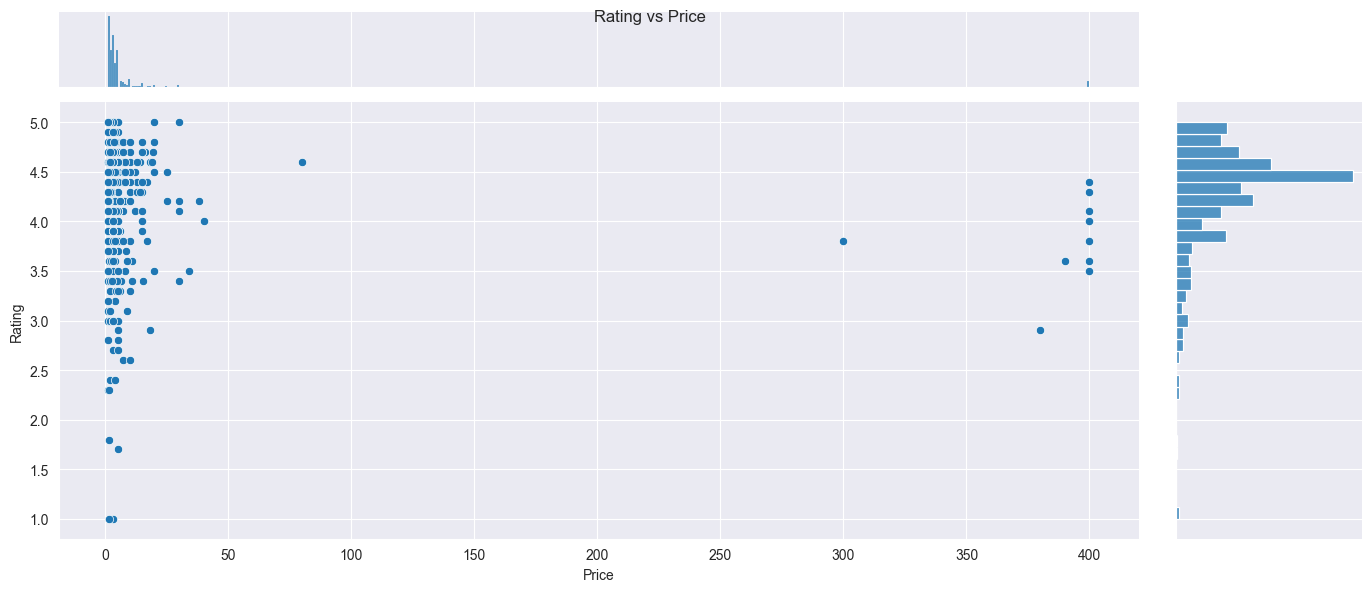

In [128]:
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings("ignore")

apps_with_size_and_rating_present = apps[apps['Rating'].notnull() & apps['Size'].notnull()]
# print(apps_with_size_and_rating_present)

large_categories = apps_with_size_and_rating_present.groupby('Category').filter(lambda x: len(x) >= 250)
# print(large_categories)

plt1 = sns.jointplot(x = large_categories['Size'], y = large_categories['Rating'])
plt1.fig.set_figwidth(15)
plt1.fig.suptitle('Rating vs Size')

paid_apps = apps_with_size_and_rating_present[apps_with_size_and_rating_present['Type']=='Paid']

plt2 = sns.jointplot(x = paid_apps['Price'], y = paid_apps['Rating'])
plt2.fig.set_figwidth(15)
plt2.fig.suptitle('Rating vs Price')


## 6. Analisis Hubungan Antara Kategori dan Aplikasi
<p>Bagaimana perusahaan dan developer aplikasi dapat memenuhi tujuan perusahaan? Strategi monetisasi apa yang dapat digunakan perusahaan untuk memaksimalkan keuntungan? Biaya pembuatan dan maintenance aplikasi sebagian besar didasarkan pada jumlah fitur, kompleksitas aplikasi, dan biaya platform.</p>

<p>Ada banyak faktor yang perlu dipertimbangkan saat memilih strategi penentuan harga yang tepat untuk aplikasi digital. Penting untuk mempertimbangkan kesediaan user untuk membayar aplikasi digital. Calon user bisa jadi tidak tertarik dengan harga yang mereka anggap terlalu mahal atau mereka mungkin akan menghapus aplikasi yang telah mereka download setelah menerima terlalu banyak iklan dalam aplikasi gratis atau tidak mendapatkan apa yang mereka harapkan.</p>

<p>Kategori yang berbeda membutuhkan harga yang berbeda. Beberapa aplikasi yang sederhana dan digunakan setiap hari, seperti aplikasi to-do list, mungkin harus tetap gratis. Namun, akan masuk akal untuk memasang biaya untuk aplikasi medis yang cukup canggih seperti untuk mendiagnosis pasien diabetes.

Analisis ini menghasilkan bahwa aplikasi dengan kategori <em>Medical and Family</em> merupakan aplikasi yang paling mahal bahkan hingga mencapai $80.</p>

,Category,App,Price
3327,FAMILY,most expensive app (H),399.99
3465,LIFESTYLE,💎 I'm rich,399.99
3469,LIFESTYLE,I'm Rich - Trump Edition,400.00
4396,LIFESTYLE,I am rich,399.99
4398,FAMILY,I am Rich Plus,399.99
4399,LIFESTYLE,I am rich VIP,299.99
4400,FINANCE,I Am Rich Premium,399.99
4401,LIFESTYLE,I am extremely Rich,379.99
4402,FINANCE,I am Rich!,399.99
4403,FINANCE,I am rich(premium),399.99


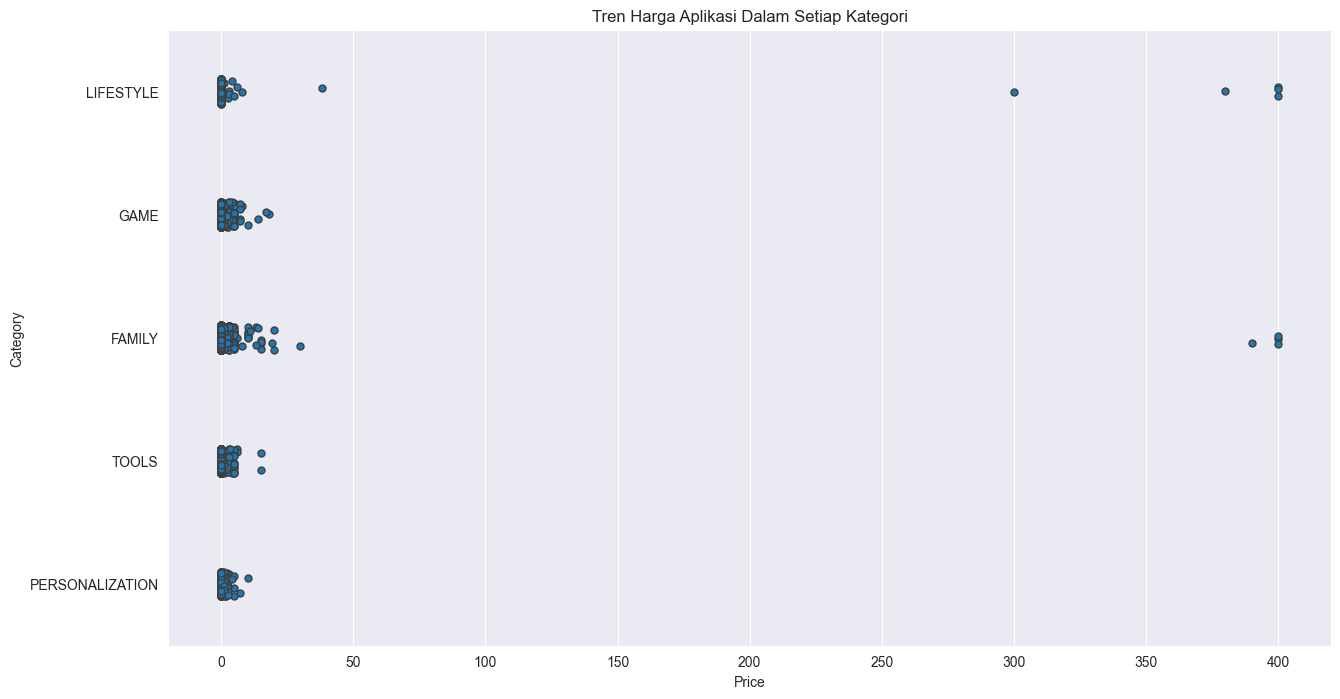

In [129]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

popular_app_cats = apps[apps.Category.isin(sorted_num_apps_in_category[:5].index)]

ax = sns.stripplot(x = popular_app_cats['Price'], y = popular_app_cats['Category'], jitter=True, linewidth=1)
ax.set_title('Tren Harga Aplikasi Dalam Setiap Kategori')

apps_above_200 = apps[apps['Price']>200]
apps_above_200[['Category', 'App', 'Price']]


## 7. Filter Aplikasi Outlier
<p>Dalam plot sebelumnya, terdapat outlier pada kolom-kolom <code>Family</code>. Dapat dilihat bahwa aplikasi-aplikasi dengan nama <em>I Am Rich Premium</em> atau <em>most expensive app (H)</em> ada karena mungkin untuk melakukan testing untuk mendeploy aplikasi digital ke dalam Play Store atau bisa jadi beberapa developer memasukkan virus seperti ransomware ke dalam aplikasi tersebut untuk memeras user yang men-download aplikasi tersebut.</p>

Text(0.5, 1.0, 'Trend Harga Aplikasi Dalam Setiap Kategori Setelah Filter')

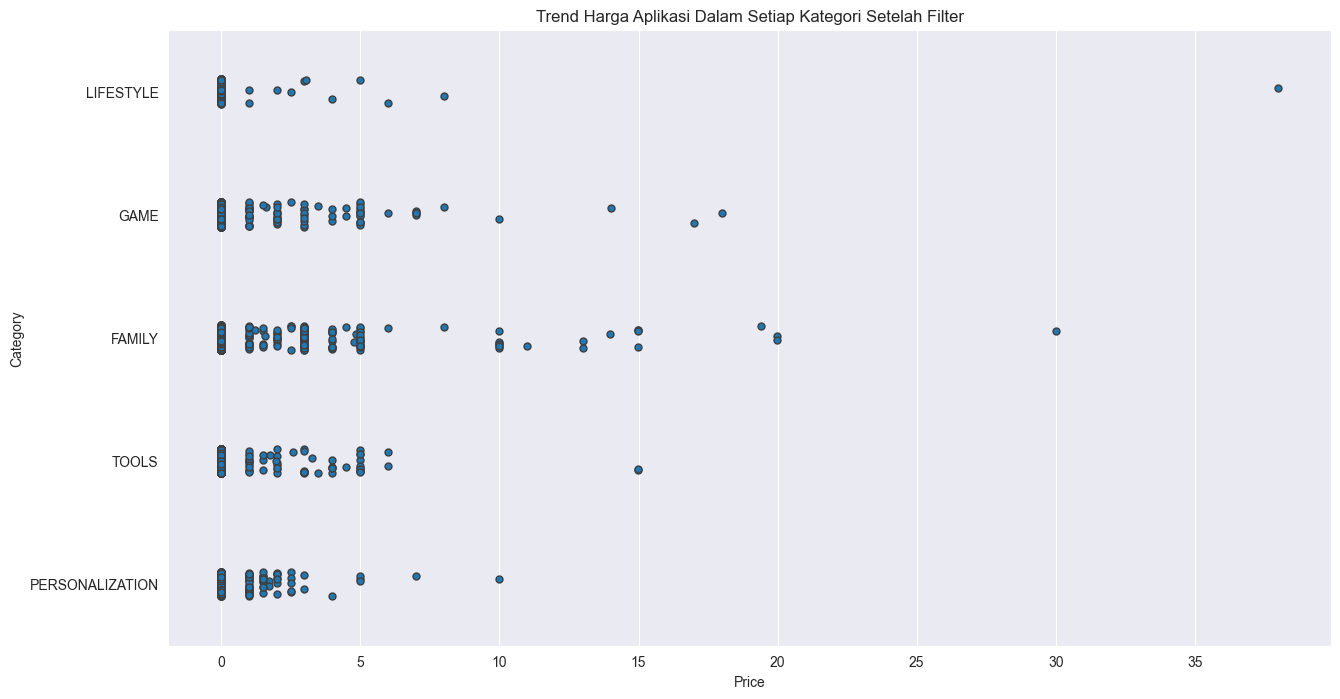

In [130]:
apps_under_100 = popular_app_cats[popular_app_cats['Price']<100]

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

ax = sns.stripplot(x = 'Price', y = 'Category', data = apps_under_100, jitter = True, linewidth = 1)
ax.set_title('Trend Harga Aplikasi Dalam Setiap Kategori Setelah Filter')


In [131]:
apps_under_100[['Category', 'App', 'Price']].sort_values('Price', ascending=False)


,Category,App,Price
4404,LIFESTYLE,I am Rich Person,37.99
4525,FAMILY,AP Art History Flashcards,29.99
6428,FAMILY,USMLE Step 2 CK Flashcards,19.99
7610,FAMILY,DRAGON QUEST VIII,19.99
6301,FAMILY,boattheory.ch Full 2018,19.40
...,...,...,...
4357,GAME,Shoot Strike War Fire,0.00
4359,FAMILY,University of Alabama,0.00
4363,FAMILY,Alabama DMV Permit Test - AL,0.00
4371,FAMILY,Al jazeera TV,0.00


## 8. Popularitas Aplikasi Berbayar vs Aplikasi Gratis
<p>Di Play Store saat ini, ada lima jenis strategi penetapan harga: gratis, freemium, berbayar, dan berlangganan. Fokus dalam analisis ini adalah aplikasi gratis dan berbayar. Beberapa karakteristik aplikasi gratis adalah:</p>
<ul>
<li>Gratis untuk di download.</li>
<li>Sumber pemasukan utama untuk developer aplikasi berasal dari iklan.</li>
<li>Sering dibuat oleh perusahaan yang memiliki produk lain dan aplikasi digital tersebut membantu produk tersebut.</li>
<li>Dapat berfungsi sebagai alat untuk retensi pelanggan, komunikasi, dan layanan pelanggan.</li>
</ul>
<p>Beberapa karakteristik aplikasi berbayar adalah:</p>
<ul>
<li>User diminta untuk membayar satu kali agar aplikasi dapat diunduh dan digunakan.</li>
<li>User tidak bisa benar-benar merasakan aplikasi sebelum membelinya.</li>
</ul>

<p>Apakah aplikasi berbayar diinstal sebanyak aplikasi gratis? Ternyata aplikasi berbayar memiliki jumlah penginstalan yang relatif lebih rendah daripada aplikasi gratis.</p>

In [139]:
print(apps[apps['Type'] == "Paid"]['Installs'].mean())
print(apps[apps['Type'] == "Paid"]['Installs'].describe())


78418.89053803339
count    5.390000e+02
mean     7.841889e+04
std      4.681338e+05
min      1.000000e+00
25%      1.000000e+03
50%      5.000000e+03
75%      1.000000e+04
max      1.000000e+07
Name: Installs, dtype: float64
0.25   NaN
0.75   NaN
Name: Installs, dtype: float64


In [133]:
print(apps[apps['Type'] == "Free"]['Installs'].mean())
print(apps[apps['Type'] == "Free"]['Installs'].describe())


4837128.345572354
count    6.482000e+03
mean     4.837128e+06
std      2.822438e+07
min      1.000000e+00
25%      1.000000e+04
50%      1.000000e+05
75%      1.000000e+06
max      1.000000e+09
Name: Installs, dtype: float64


In [134]:
trace0 = go.Box(
    y = apps[apps['Type'] == "Paid"]['Installs'],
    name = 'Paid'
)

trace1 = go.Box(
    y = apps[apps['Type'] == "Free"]['Installs'],
    name = 'Free'
)

layout = go.Layout(
    title = "Jumlah download Aplikasi Berbayar vs. Aplikasi Gratis",
    yaxis = dict(title = "Jumlah Download (log)",
                type = 'log',
                autorange = True)
)

data = [trace0, trace1]
plotly.offline.iplot({'data': data, 'layout': layout})


## 9. Analisis Sentimen Berdasarkan Review User
<p>Data ulasan pengguna dapat digunakan untuk menentukan bagaimana sentimen pengguna terhadap produk yang mereka gunakan. Ulasan pengguna untuk aplikasi dapat dianalisis untuk mengidentifikasi apakah respon mereka positif, negatif, atau netral terhadap aplikasi tersebut. Misalnya, kata-kata positif dalam ulasan aplikasi dapat mencakup kata-kata seperti 'luar biasa', 'ramah', 'bagus', 'hebat', dan 'cinta'. Kata-kata negatif mungkin berupa kata-kata seperti 'malware', 'benci', 'masalah', 'refund', dan 'tidak kompeten'.</p>

<p>Dengan memvisualisasikan skor polaritas sentimen untuk aplikasi berbayar dan gratis, dapat dilihat bahwa aplikasi gratis menerima banyak komentar kasar, seperti yang ditunjukkan oleh outlier pada sumbu y negatif. Ulasan untuk aplikasi berbayar tampaknya tidak pernah sangat negatif. Hal ini mungkin mengindikasikan sesuatu tentang kualitas aplikasi, yaitu aplikasi berbayar memiliki kualitas yang lebih tinggi daripada aplikasi gratis.</p>

In [135]:
reviews_df = pd.read_csv('./datasets/user_reviews.csv')

merged_df = apps.merge(reviews_df)

merged_df = merged_df.dropna(subset = ['Sentiment', 'Review'])
merged_df.head()


,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,A kid's excessive ads. The types ads allowed a...,Negative,-0.250,1.000000
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,It bad >:(,Negative,-0.725,0.833333
2,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,like,Neutral,0.000,0.000000
4,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,I love colors inspyering,Positive,0.500,0.600000
5,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,I hate,Negative,-0.800,0.900000


In [136]:
trace0 = go.Box(
    y = merged_df[merged_df['Type'] == "Paid"]['Sentiment_Polarity'],
    name = 'Paid'
)

trace1 = go.Box(
    y = merged_df[merged_df['Type'] == "Free"]['Sentiment_Polarity'],
    name = 'Free'
)

layout = go.Layout(
    title = "Boxplot Sentimen Aplikasi Berbayar vs. Aplikasi Gratis",
    yaxis = dict(title = "Polaritas Sentimen",
                autorange = True)
)

data = [trace0, trace1]
plotly.offline.iplot({'data': data, 'layout': layout})


In [137]:
import plotly.express as px

pie_sentiment = merged_df['Sentiment'].value_counts().reset_index()

pie_sentiment.columns = ['Sentiment', 'count']

fig = px.pie(pie_sentiment, values='count', names='Sentiment', title='Persentase Aplikasi Berdasarkan Sentimen')
fig.show()
